# Hyperparameters for RF

In [1]:
%load_ext autoreload
%autoreload 2

# 1. Importing Libraries 

In [2]:
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline



import os, sys, pickle, copy, joblib

from pathlib import Path

DIR = Path().resolve() 

import pandas as pd
import numpy as np
from time import sleep
from tqdm import tqdm, tqdm_notebook
import AFQ_utils as utils
from matplotlib import pyplot as plt

import seaborn as sns; sns.set()
sns.set_theme(style="white")

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer , r2_score, mean_absolute_error, explained_variance_score, \
mean_absolute_percentage_error, mean_squared_error, max_error, median_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_selector as selector



plt_params = {
    "axes.titlesize" : 25, # main
    "axes.labelsize" : 20,  # labels
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 1, 
    'xtick.labelsize': 17, # ticks
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
}




# for windows
#from sklearnex import patch_sklearn
#patch_sklearn()

define constants and dcitionaries to easy looping

In [3]:
obs = pd.DataFrame()


obs["OBS_REF"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV","PV", 
            "GEOID","FA","DEM","BG", "EMAG2_CLASS",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST_W", "REG", "GLIM"]

obs["OBS_AFR"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV_SPEED","PV_SPEED", 
            "GEOID","FA","DEM","BG", "EMAG2",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST", "REG", "GLIM"]
  
     
# Labels for plots etc


# Labels for plots etc
obs["LABELS_gmt"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "S@_v@ 150km", "P@_v@ 150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. rho", "Crust rho",  
                 "Volcano", "REG", "GliM", ]  


obs["LABELS"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "$S_v$ @150km", "$P_v$ @150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. ρ", "Crust ρ",  
                 "Volcano", "REG", "GliM", ]
    
# "vp/vs"
# Units to display in plots etc
obs["UNITS"] = ["km",  "si", "km", "km",
             "$\delta$$S_v$ %","$\delta$$P_v$ %", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m$^3$", "kg/m$^3$",
                "km",  "class", "class"]



obs["UNITS_gmt"] = ["km",  "si", "km", "km",
             "km/s","km/s", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m@+3@+", "kg/m@+3@+",
                "km",  "class", "class"]
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs["V_RANGE"] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,16),]


    
obs["V_RANGE_AFR"] = [(0,50), (-1,1),(50,250),(20,50),
          (-0.075,0.075), (-0.02,0.02), 
          (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-200, 200), 
               (3260, 3360), (2650, 2950),
              (0,100), (1,6),(1,15),]


obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", 
             "bamako", "broc", "bukavu", "broc", "batlow",            
                "batlow", "batlow",
               "bamako",  "batlowS","categorical", ]

obs["CMAPS"] = ["SCM/bamako",  "SCM/broc", "SCM/bamako", "SCM/bamako", 
             "SCM/roma","SCM/roma", 
             "SCM/bamako", "SCM/broc", "SCM/oleron", "SCM/broc", "SCM/bilbao",            
                "SCM/batlow", "SCM/batlow",
               "SCM/broc",  "gmt/categorical","gmt/categorical", ]

new_index = [0,1,2,3,4,5,6,8,7,9,10,11,12,13,14,15]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

obs = obs.reindex(new_index)

#obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 16




obs_dict = obs.to_dict(orient='records')

obs.set_index(['OBS_REF'], inplace=True)



obs

,OBS_AFR,LABELS_gmt,LABELS,UNITS,UNITS_gmt,V_RANGE,V_RANGE_AFR,CMAPS
OBS_REF,,,,,,,,
CTD,CTD,CTD,CTD,km,km,"(0, 50)","(0, 50)",SCM/bamako
SI,SI,Shape index,Shape index,si,si,"(-1, 1)","(-1, 1)",SCM/broc
LAB,LAB,LAB,LAB,km,km,"(0, 300)","(50, 250)",SCM/bamako
MOHO,MOHO,Moho,Moho,km,km,"(15, 60)","(20, 50)",SCM/bamako
SV,SV_SPEED,S@_v@ 150km,$S_v$ @150km,$\delta$$S_v$ %,km/s,"(-0.075, 0.075)","(-0.075, 0.075)",SCM/roma
PV,PV_SPEED,P@_v@ 150km,$P_v$ @150km,$\delta$$P_v$ %,km/s,"(-0.02, 0.02)","(-0.02, 0.02)",SCM/roma
GEOID,GEOID,Geoid,Geoid,m,m,"(-45, 45)","(-45, 45)",SCM/bamako
DEM,DEM,DEM,DEM,m,m,"(-2200, 2200)","(-2200, 2200)",SCM/oleron
FA,FA,Free air,Free air,mGal,mGal,"(-100, 100)","(-100, 100)",SCM/broc


In [4]:

target = 'GHF'
coord = ['lon', 'lat']
grid_index_world = 'grid_index_world'
grid_index_afr = 'grid_index_afr'

#######

features_ex = []
features_ghf = []



features = obs.index.to_list()



in_features = set(features)

features_ex = copy.deepcopy(features)
features_ex.extend(coord)
features_ex.append(grid_index_world)
features_ex.append(grid_index_afr)

features_ex.append(target)

features_ghf = copy.deepcopy(features)
features_ghf.append(target)


features_ex

['CTD',
 'SI',
 'LAB',
 'MOHO',
 'SV',
 'PV',
 'GEOID',
 'DEM',
 'FA',
 'BG',
 'EMAG2_CLASS',
 'RHO_L',
 'RHO_C',
 'VOLC_DIST_W',
 'REG',
 'GLIM',
 'lon',
 'lat',
 'grid_index_world',
 'grid_index_afr',
 'GHF']

In [5]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    
    y_true = y_true.ravel().reshape(-1,)
    y_pred = y_pred.ravel().reshape(-1,)
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) 

def accuracy(y_true, y_pred):
    cost  = mean_absolute_percentage_error(y_true, y_pred)
    return (100 - (cost * 100)) 

def min_e(y_true, y_pred):
    cost  = abs(y_true - y_pred)
    return cost.min()

def mpe(y_true, y_pred):
    return np.mean((y_true -y_pred)/y_true) 



scores_cv = {

'RMSE'     :  make_scorer(mean_squared_error , squared=False),
'NRMSE'    :  make_scorer(nrmse),
'MAE'      :  make_scorer(mean_absolute_error),    
'MAPE'     :  make_scorer(mean_absolute_percentage_error ),
'ACC'      :  make_scorer(accuracy) ,
'MPE'      :  make_scorer(mpe),
'CD'       :  make_scorer(r2_score),
'EV'       :  make_scorer(explained_variance_score),
'MAX_E'    :  make_scorer( max_error),
'MIN_E'    :  make_scorer(min_e),
'MedAE'    :  make_scorer(median_absolute_error),
'CCC'      :  make_scorer(concordance_correlation_coefficient),
    
}

# 3. Determining ranges for Hyperparameters tuning

In [7]:

KFOLD=5
N_ITER=30
RANDOM_STATE=42
N_JOBS=2
VERBOSE=4

grid_search_dict = { }

train_df = pd.read_csv(DIR /'Dataset'/'Preprocessed'/f'W_OD_rab.csv', sep='\t')

X = train_df[features]
y = train_df[target] 

X['GLIM']  = X['GLIM'].astype('int').astype('category')
X['REG']   = X['REG'].astype('int').astype('category')



#scoring = make_scorer(nrmse , greater_is_better=False )
SCORING = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
CV = KFold(n_splits=KFOLD, random_state=RANDOM_STATE, shuffle=True)


# param distribution
n_estimators      =  np.arange(100, 1500,50) # overfits
max_depth         =  list(range(5,100,3)); max_depth.append(None); # overfits
max_features      =  list(range(1, X.shape[1]))  # overfits 
#min_samples_leaf  =  np.linspace(1, 0.5*X.shape[0], 10)# underfits
min_samples_leaf  =  list(range(1, int(0.2*X.shape[0]), 1))# underfits
min_samples_split =  np.linspace(2, X.shape[0], 500, dtype='int') # underfits

#min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)




# Update dict with Extra Trees
search_space = { 
         'ttr__regressor__n_estimators'     : n_estimators, 
         'ttr__regressor__max_depth'        : max_depth, 
         'ttr__regressor__max_features'     : max_features,  
         'ttr__regressor__min_samples_leaf' : min_samples_leaf,  
         'ttr__regressor__min_samples_split': min_samples_split,  
}

 #Create train and test set  

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True)


for key, seach_value in tqdm_notebook(search_space.items(), desc = 'Processing: '):
    print(key)
    numeric_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    preprocessor = ColumnTransformer(
        transformers=[
               ("num", numeric_transformer, selector(dtype_exclude="category")),
               ("cat", categorical_transformer, selector(dtype_include="category")),
        ], 
        #remainder='passthrough', verbose_feature_names_out=False
    )


    regressor = RandomForestRegressor(random_state=RANDOM_STATE)

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.

    steps=[("preprocessor", preprocessor), 
           #("regressor", regressor), 
           ('ttr', TransformedTargetRegressor(regressor=regressor, transformer=numeric_transformer))
          ]

    # Initialize Pipeline object
    pipeline = Pipeline(steps=steps)
    
    # GRIDSEACH
    #grid_reg_gs = GridSearchCV(pipeline, 
    #                    param_grid={key: seach_value},  
    #                    n_iter=N_ITER,
    #                    return_train_score=True, 
    #                    random_state=RANDOM_STATE ,
    #                    scoring=SCORING, 
    #                    cv=CV, 
    #                    verbose=VERBOSE, 
    #                    n_jobs=N_JOBS
    #               )
    
    #grid_reg_gs.fit(X, y)
    #grid_search_dict[key] = grid_reg_gs
    
    #RANDOMSEARCH
    grid_reg_rs = RandomizedSearchCV(pipeline, 
                        param_distributions={key: seach_value},
                        n_iter=N_ITER,
                        return_train_score=True, 
                        random_state=RANDOM_STATE ,
                        scoring=SCORING, 
                        cv=CV, 
                        verbose=VERBOSE, 
                        n_jobs=N_JOBS
                   )
    grid_reg_rs.fit(X, y)
    grid_search_dict[key] = grid_reg_rs

    # HALVINGGRIDSEARCH
    #grid_halving_cv = HalvingGridSearchCV(pipeline,
    #                    param_grid = {key: seach_value}, 
    #                    n_iter=N_ITER,
    #                    return_train_score=True, 
    #                    random_state=RANDOM_STATE ,
    #                    scoring=SCORING, 
    #                    cv=CV, 
    #                    verbose=VERBOSE, 
    #                    n_jobs=N_JOBS
    #                    )

    #grid_halving_cv = HalvingRandomSearchCV(pipeline,
    #                    param_grid = {key: seach_value}, 
    #                    n_iter=N_ITER,
    #                    return_train_score=True, 
    #                    random_state=RANDOM_STATE ,
    #                    scoring=SCORING, 
    #                    cv=CV, 
    #                    verbose=VERBOSE, 
    #                    n_jobs=N_JOBS
    #                   )
    #grid_halving_cv.fit(X, y)
    
    #grid_search_dict[key] = grid_halving_cv
print('Terminated')

Processing:   0%|          | 0/5 [00:00<?, ?it/s]

ttr__regressor__n_estimators
Fitting 5 folds for each of 28 candidates, totalling 140 fits
ttr__regressor__max_depth
Fitting 5 folds for each of 30 candidates, totalling 150 fits
ttr__regressor__max_features
Fitting 5 folds for each of 15 candidates, totalling 75 fits
ttr__regressor__min_samples_leaf
Fitting 5 folds for each of 30 candidates, totalling 150 fits
ttr__regressor__min_samples_split
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Terminated


In [12]:
plt.rcParams.update(plt_params)
for key, grid in grid_search_dict.items():
    utils.plot_grid_search(grid, catgeories=[False]) 

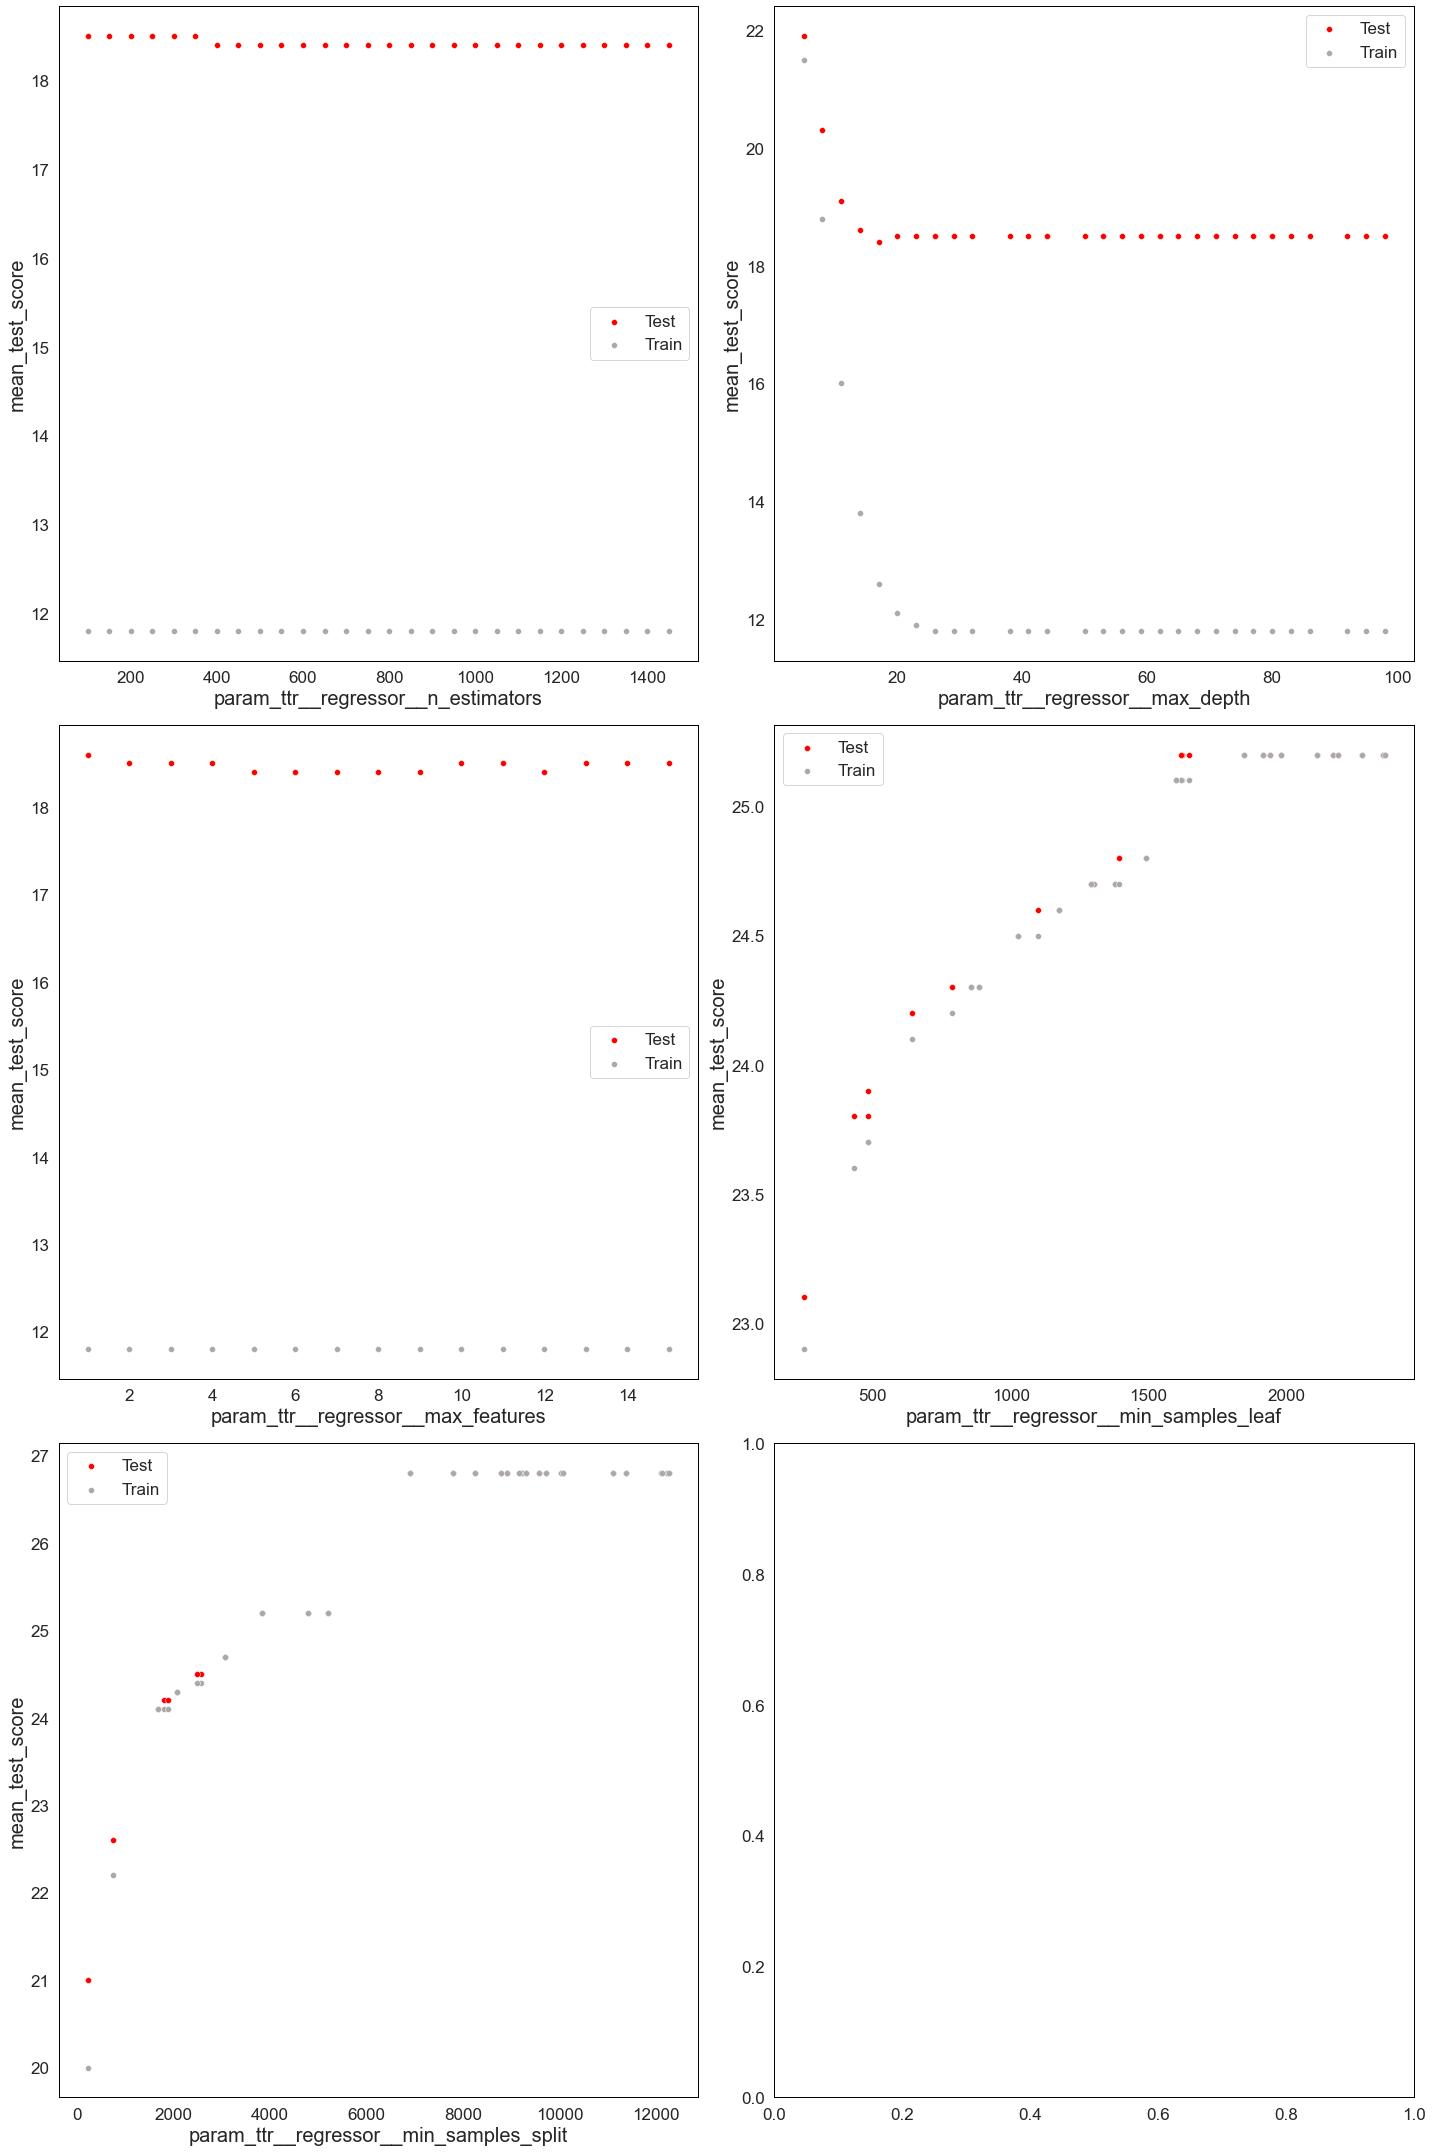

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=3)

plt.rcParams.update(plt_params)
 
fig.set_size_inches(20,30)
axs = axs.ravel()


plt.rcParams.update(plt_params)

#sns.set(style="whitegrid", color_codes=True, font_scale = 2)



i = 0

for key, grid in grid_search_dict.items():
    
    grid_df = pd.DataFrame.from_dict(grid.cv_results_)
    grid_df['mean_test_score'] = grid_df['mean_test_score'].round(1) *-1
    grid_df['mean_train_score'] = grid_df['mean_train_score'].round(1) *-1
    
    sns.scatterplot(f'param_{key}', 'mean_test_score' , 
                 data=grid_df, 
                 ax=axs[i] ,  color='red', label ='Test',)
    sns.scatterplot(f'param_{key}', 'mean_train_score' , 
                 data=grid_df , 
                 ax=axs[i] , color='darkgrey', label ='Train',)
    i+=1
    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout()

plt.show()

In [18]:
KFOLD=5
N_ITER=150
RANDOM_STATE=42
N_JOBS=3
VERBOSE=4

# readjust the ranges

# param distribution
n_estimators      =  np.arange(250, 550,50) # overfits
max_depth         =  list(range(10,25,1)); max_depth.append(None); # overfits
max_features      =  list(range(3, 8))  # overfits 
min_samples_leaf  =  list(range(1, 50, 1))# underfits
min_samples_split =  list(range(2, 100, 5)) # underfits



# Update dict with Extra Trees
search_space = { 
         'ttr__regressor__n_estimators'     : n_estimators, 
         'ttr__regressor__max_depth'        : max_depth, 
         'ttr__regressor__max_features'     : max_features,  
         'ttr__regressor__min_samples_leaf' : min_samples_leaf,  
         'ttr__regressor__min_samples_split': min_samples_split,  
}

 #Create train and test set  

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)



numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)

preprocessor = ColumnTransformer(
    transformers=[
           ("num", numeric_transformer, selector(dtype_exclude="category")),
           ("cat", categorical_transformer, selector(dtype_include="category")),
    ], 
    #remainder='passthrough', verbose_feature_names_out=False
)


regressor = RandomForestRegressor(random_state=RANDOM_STATE)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

steps=[("preprocessor", preprocessor), 
       #("regressor", regressor), 
       ('ttr', TransformedTargetRegressor(regressor=regressor, transformer=numeric_transformer))
      ]

# Initialize Pipeline object
pipeline = Pipeline(steps=steps)




# GRIDSEACH
#grid_reg_gs = GridSearchCV(pipeline, 
    #                    param_grid=search_space, 
    #                    return_train_score=True, 
    #                    random_state=RANDOM_STATE ,
    #                    scoring=SCORING, 
    #                    cv=CV, 
    #                    verbose=VERBOSE, 
    #                    n_jobs=N_JOBS
    #          )


#print('#'*60)
#print(f"Now tuning.")

#grid_reg_gs.fit(X, y)

#best_params = grid_reg_gs.best_params_
#best_score = grid_reg_gs.best_score_

#RANDOMSEARCH



#grid_reg_rs =  RandomizedSearchCV(pipeline, 
    #                    param_distributions=search_space, 
    #                    n_iter=N_ITER,
    #                    return_train_score=True, 
    #                    random_state=RANDOM_STATE ,
    #                    scoring=SCORING, 
    #                    cv=CV, 
    #                    verbose=VERBOSE, 
    #                    n_jobs=N_JOBS
    #         )

#print('#'*60)
#print(f"Now tuning.")

#grid_reg_rs.fit(X, y)

#best_params = grid_reg_rs.best_params_
#best_score = grid_reg_rs.best_score_


# HALVINGGRIDSEARCH
#halving_cv = HalvingGridSearchCV(pipeline, 
#                        param_grid=search_space, 
#                        return_train_score=True, 
#                        random_state=RANDOM_STATE ,
#                        scoring=SCORING, 
#                        cv=CV, 
#                        verbose=VERBOSE, 
#                        n_jobs=N_JOBS
#             )

'''halving_cv = HalvingRandomSearchCV(pipeline, 
                                param_distributions=search_space, 
                                return_train_score=True, 
                                random_state=RANDOM_STATE ,
                                scoring=SCORING, 
                                cv=CV, 
                                verbose=VERBOSE, 
                                n_jobs=N_JOBS
             )

#print('#'*60)
#print(f"Now tuning.")

halving_cv.fit(X, y)

best_params = halving_cv.best_params_
best_score = halving_cv.best_score_'''

###BEYSIANSEARCH

# Initialize BaysSearch object   

Bayesian_cv = BayesSearchCV(
    pipeline,
    # (parameter space, # of evaluations)
    search_space,
    n_iter = N_ITER, 
    cv = CV, 
    verbose = VERBOSE, 
    n_jobs=N_JOBS, 
    scoring= SCORING,
    return_train_score=True,
    #refit=False,
    random_state=RANDOM_STATE 
)



# Print message to user
print('#'*60)
print(f"Now tuning.")

# Fit gscv
Bayesian_cv.fit(X, y)  

# Get best parameters and score
best_params = Bayesian_cv.best_params_
best_score = Bayesian_cv.best_score_


print('terminated')

############################################################
Now tuning.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
terminated


In [19]:
#scoring evaluation comparing baseline and tuned algorithm
    
for key, scoring in tqdm_notebook( scores_cv.items(), desc='Scoring: ' ):
    
    numeric_transformer = PowerTransformer(method='yeo-johnson',standardize=True)
    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)

    preprocessor = ColumnTransformer(
        transformers=[
               ("num", numeric_transformer, selector(dtype_exclude="category")),
               ("cat", categorical_transformer, selector(dtype_include="category")),
        ], 
        #remainder='passthrough', verbose_feature_names_out=False
    )


    regressor = RandomForestRegressor(random_state=RANDOM_STATE)

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.

    steps=[("preprocessor", preprocessor), 
           #("regressor", regressor), 
           ('ttr', TransformedTargetRegressor(regressor=regressor, transformer=numeric_transformer))
          ]

    # Initialize Pipeline object
    pipeline = Pipeline(steps=steps)



    score_default  = np.mean(cross_validate(
                pipeline, 
                X, 
                y,
                 n_jobs=N_JOBS,
                scoring=scoring,
                  cv=CV)['test_score'])

    pipeline.set_params(**best_params)

    score_tuned  = np.mean(cross_validate(
                pipeline, 
                X, 
                y,
                n_jobs=N_JOBS,
                scoring=scoring,
                  cv=CV)['test_score'])
    print(f'{key} before: {score_default:.2f}; after: {score_tuned:.2f}; ratio: {(score_default - score_tuned)/score_default*100:.2f}% \n')
print('terminated')

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

RMSE before: 18.50; after: 18.25; ratio: 98.67% 

NRMSE before: 0.29; after: 0.29; ratio: 98.67% 

MAE before: 12.12; after: 12.06; ratio: 99.52% 

MAPE before: 0.21; after: 0.21; ratio: 99.81% 

ACC before: 78.77; after: 78.81; ratio: 100.05% 

MPE before: -0.06; after: -0.05; ratio: 99.10% 

CD before: 0.51; after: 0.53; ratio: 102.52% 

EV before: 0.52; after: 0.53; ratio: 102.76% 

MAX_E before: 134.72; after: 129.46; ratio: 96.10% 

MIN_E before: 0.00; after: 0.01; ratio: 195.54% 

MedAE before: 7.45; after: 7.51; ratio: 100.70% 

CCC before: 0.69; after: 0.69; ratio: 99.53% 

terminated


In [20]:
#saving results

best_parms_df = pd.DataFrame.from_dict([best_params])

# save best results and model
best_parms_df.to_csv(DIR /'Hyperparameters'/f'BS_hyperparameter.csv' , index=False, sep='\t')

joblib.dump(Bayesian_cv, DIR /'Hyperparameters'/f'BSCV_model.pkl')




dropped_columns = ['mean_fit_time', 'std_fit_time',  'params', 'mean_score_time', 'std_score_time']

# all hyp results
# gives traing and validation results
bs_grid_df = pd.DataFrame(Bayesian_cv.cv_results_)

bs_grid_df = bs_grid_df.sort_values(f'rank_test_score', ascending=True).reset_index(drop=True).copy(deep=True)

bs_grid_df['mean_test_score'] = bs_grid_df['mean_test_score'] *-1
bs_grid_df['mean_train_score'] = bs_grid_df['mean_train_score'] *-1

split_test = [f'split{x}_test_score' for x in range(KFOLD)]
split_train = [f'split{x}_train_score' for x in range(KFOLD)]

dropped_columns.extend(split_test)
dropped_columns.extend(split_train)


#save results

bs_grid_df.to_csv(DIR/'Hyperparameters'/f'BSCV_grid.csv' , index=False, sep='\t')




# 4. Hyperparameters visualization

OrderedDict([('ttr__regressor__max_depth', 20), ('ttr__regressor__max_features', 6), ('ttr__regressor__min_samples_leaf', 2), ('ttr__regressor__min_samples_split', 2), ('ttr__regressor__n_estimators', 450)])


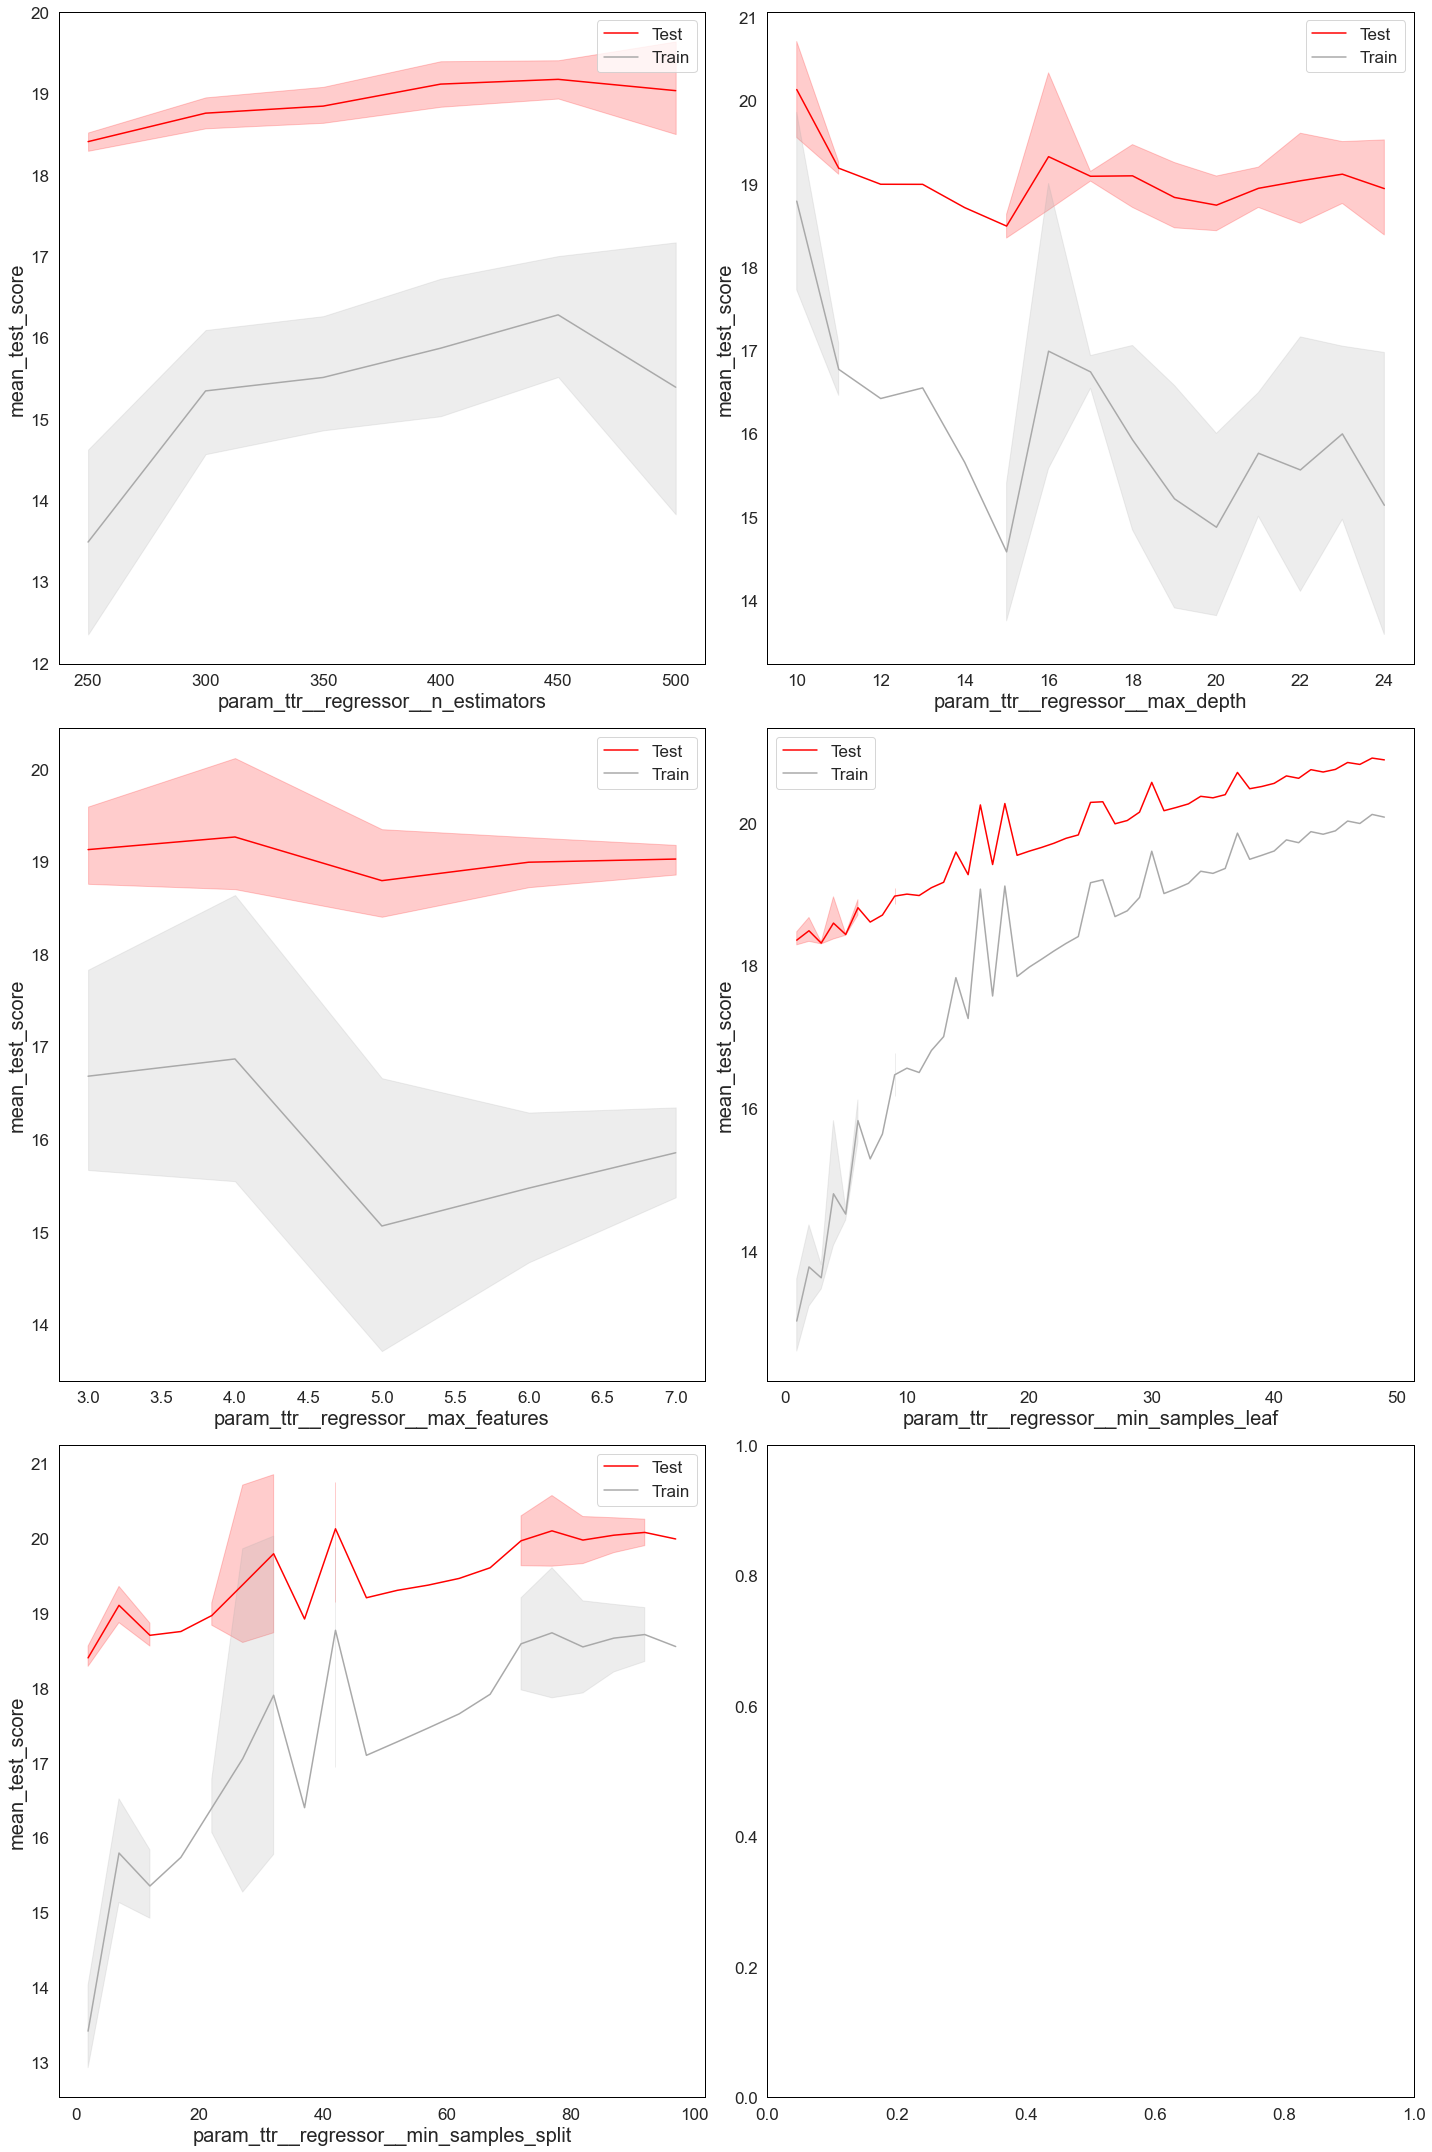

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=3)

plt.rcParams.update(plt_params)

fig.set_size_inches(20,30)
axs = axs.ravel()

params = ['param_ttr__regressor__n_estimators', 
 'param_ttr__regressor__max_depth',
 'param_ttr__regressor__max_features',
 'param_ttr__regressor__min_samples_leaf',
'param_ttr__regressor__min_samples_split'
         ]


grid_df = pd.read_csv(DIR/'Hyperparameters'/f'BSCV_grid.csv', sep='\t')

plt.rcParams.update(plt_params)

#sns.set(style="whitegrid", color_codes=True, font_scale = 2)


print(best_params)

i = 0

for i,param in enumerate(params):
    
    grid_df['mean_test_score'] = grid_df['mean_test_score'] 
    grid_df['mean_train_score'] = grid_df['mean_train_score'] 
    
    sns.lineplot(f'{param}', 'mean_test_score' , 
                 data=grid_df, 
                 ax=axs[i] ,  color='red', label ='Test',)
    sns.lineplot(f'{param}', 'mean_train_score' , 
                 data=grid_df , 
                 ax=axs[i] , color='darkgrey', label ='Train',)
    i+=1
    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.tight_layout()

plt.show()



In [23]:
categories = [False, False, False, False, False, ]


    
bscv_i =  DIR/'Hyperparameters'/f'BSCV_model.pkl'

bscv = joblib.load(bscv_i)
utils.plot_grid_search(bscv, catgeories=categories)



